<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Flag_of_Quebec.svg/320px-Flag_of_Quebec.svg.png">
</td>


# Analyse des sources de l'édition québécoise du *Huff Post* (2012-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre <i>notebook</i> et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Québec"
huff = huff[huff.pays == edition]
huff.shape

(390231, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

Le Huffington Post           390214
The Huffington Post          5     
Huffington Post India        3     
허핑턴포스트                       2     
ハフィントンポスト                    2     
L'Huffington Post            2     
El Huffington Post           1     
Al Huffington Post           1     
Huffington Post Australia    1     
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

Le Huffington Post           390214
The Huffington Post          5     
Huffington Post India        3     
허핑턴포스트                       2     
ハフィントンポスト                    2     
L'Huffington Post            2     
El Huffington Post           1     
Al Huffington Post           1     
Huffington Post Australia    1     
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(390231, 13)

In [7]:
len(huff) - len(huff[metaHP])

0

Le calcul ci-haut nous indique que la balise `meta` des articles du *HuffPost&nbsp;Québec* donne à penser qu'ils ont **tous** été rédigés par l'équipe maison.
<hr>
Examinons-les quand même de plus près en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? AFPQC2                                                                   76046
Par AFP AFPQC                                                              68613
? RCQC                                                                     39991
Par The Associated Press CP                                                36530
Par La Presse Canadienne CP                                                25948
Par Radio-Canada.ca RCQC                                                   15058
Par La Presse Canadienne PC                                                9810 
? Le Huffington Post Québec                                                8897 
Par Agence France-Presse AFPQC                                             8827 
Par Relaxnews AFPRelQC                                                     8827 
? Le HuffPost                                                              4187 
Par Agence France Presse AFPQC                                             3505 
                            

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent à peine **0,4%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(1439, 0.36875594199333217)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(42782, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? Le Huffington Post Québec                                             8897
 ? Le HuffPost                                                           4187
 Par Marie-Josée Roy Le Huffington Post Québec                           2280
 Par Ismaël Houdassine Le Huffington Post Québec                         790 
 Par Alexis Ferenczi Le HuffPost                                         726 
 ? The Huffington Post                                                   711 
 Par Mélissa Pelletier Le Huffington Post Québec                         706 
 ? The Huffington Post Canada                                            626 
 ? Le HuffPost/AFP                                                       583 
 ? Huffington Post Québec                                                574 
 Par Jean-François Cyr Le Huffington Post Québec                         433 
 Par Samuel Larochelle Le Huffington Post Québec                         422 
                                                                

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **42&nbsp;782 articles** signés par **2&nbsp;982 signataires différents**.<br>
Cela représente près de **11%** seulement de l'ensemble des articles publiés par l'édition québécoise du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(42782, 10.963249972452214)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(347449, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? AFPQC2                                                              76046
 Par AFP AFPQC                                                         68613
 ? RCQC                                                                39991
 Par The Associated Press CP                                           36530
 Par La Presse Canadienne CP                                           25948
 Par Radio-Canada.ca RCQC                                              15058
 Par La Presse Canadienne PC                                           9810 
 Par Relaxnews AFPRelQC                                                8827 
 Par Agence France-Presse AFPQC                                        8827 
 Par Agence France Presse AFPQC                                        3505 
 Par La Presse canadienne PC                                           2856 
 Par The Associated Press PC                                           1929 
                                                                       ...  

On constate que lorsqu'il y a un nom de journaliste suivi d'un point d'interrogation, c'est un auteur de l'équipe du *HuffPost Québec*. C'est le cas de [Patrick Bellerose](http://quebec.huffingtonpost.ca/author/patrick-bellerose/) et de [Catherine Lévesque](http://quebec.huffingtonpost.ca/author/catherine-levesque/), pour ne nommer que ceux-là.

On va donc considérer que si la variable `byline` se termine par un point d'interrogation, il s'agira d'un auteur qui rédige des articles originaux pour le *HuffPost*.

Isolons ces auteurs.

In [15]:
auteur = huff[metaHP][NONsigneHP].byline.str.endswith(" ?")
huff[metaHP][NONsigneHP][auteur].byline.value_counts(), huff[metaHP][NONsigneHP][auteur].byline.value_counts().sum()

(Patrick Bellerose ?          842
 Catherine Lévesque ?         328
 ? ?                          236
 Daphnee Hacker-Bousquet ?    92 
 Myriam Lefebvre ?            79 
 Patrick White ?              29 
 Althia Raj ?                 23 
 Jean-Philippe Cipriani ?     11 
 Stanislas Kraland ?          10 
 Lauren Provost ?             9  
 Hadi Hassin ?                7  
 Christian Duperron ?         6  
                             ..  
 Abby Huntsman ?              1  
 Vincent Gibert ?             1  
 Adrien Oster ?               1  
 Emeline Amétis ?             1  
 Lindsay Holmes ?             1  
 Mehdi Hasan ?                1  
 秋元 祥治 ?                      1  
 Rebecca Shapiro ?            1  
 Mauro Leonardi ?             1  
 Ryan Grenoble ?              1  
 Peter S. Goodman ?           1  
 Myriam Francois-Cerrah ?     1  
 Name: byline, Length: 54, dtype: int64, 1736)

Ces auteurs ont donc signé **1&nbsp;500 articles** (1&nbsp;736 articles ci-dessus, auxquels il faut retrancher les 236 articles dont l'auteur est inconnu [«&nbsp;? ?&nbsp;»]).

On peut les ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 1500
HP_oui, (HP_oui/len(huff))*100

(44282, 11.347637681270838)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner les articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, puis retrancher tous les articles qu'on vient de ranger dans notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 1500
HP_non, (HP_non/len(huff))*100

(344510, 88.283606376735833)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

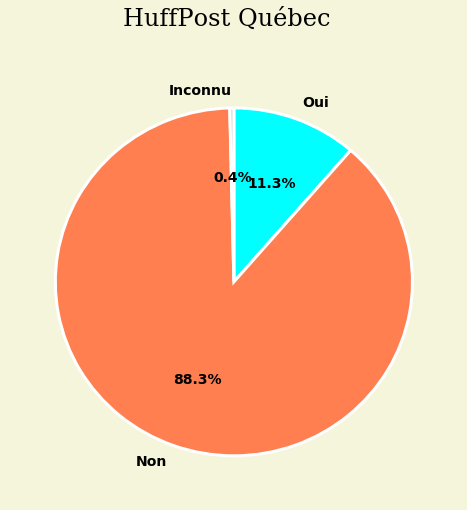

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Québec", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

Le *HuffPost Québec* inclut généralement dans ses étiquettes les sources des articles, mais pas toujours, car si on additionne les étiquettes **pc** (Presse canadienne), **afp** (Agence France-Presse) et **rc** (Radio-Canada), on arrive à 55% de sources externes, alors qu'en examinant les signataires des articles, on arrive à un proportion bien supérieure, le 88% qu'on a calculé ci-dessus.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

pc                                        103627
afp                                       79514 
hp                                        77723 
rc                                        31306 
divertissement                            23512 
Québec International                      16831 
politique                                 16225 
québec vidéo                              9406  
insolite                                  7087  
video                                     6212  
Québec Sports                             5948  
faits divers                              5711  
                                          ...   
Hery Rajaonarimampianina                  1     
Neville Jacobs instagram                  1     
soeurs Bélanger Thaïlande                 1     
Rassemblement des citoyens de Montréal    1     
La Famille Botero de Toxique Trottoir     1     
jesse england                             1     
suspects terroristes 4 juillet            1     
accident hélicoptère